In [24]:
import fastf1
from fastf1 import plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import FuncFormatter, MultipleLocator
import json

# --- FastF1 Cache Configuration ---
# Creates a cache directory for FastF1 to store downloaded data, speeding up future loads.
CACHE_DIR = './fastf1_cache'
if not os.path.exists(CACHE_DIR):
    os.makedirs(CACHE_DIR)
fastf1.Cache.enable_cache(CACHE_DIR)
print(f"FastF1 cache enabled at: {os.path.abspath(CACHE_DIR)}")

# --- Base Directory for Processed Data (for saving plots if needed) ---
# This is where generated plots might be stored if plt.savefig() is used.
# The data itself will be loaded directly from FastF1 sessions.
BASE_PLOT_DIR = './f1_plots'
if not os.path.exists(BASE_PLOT_DIR):
    os.makedirs(BASE_PLOT_DIR)
print(f"Base directory for saving plots: {os.path.abspath(BASE_PLOT_DIR)}")


plt.style.use('dark_background') 
COMPOUND_COLORS = fastf1.plotting.COMPOUND_COLORS

FastF1 cache enabled at: c:\Users\mpoli\Desktop\UFOP\8 PERIODO\PAE\Trabalho\fastf1_cache
Base directory for saving plots: c:\Users\mpoli\Desktop\UFOP\8 PERIODO\PAE\Trabalho\f1_plots


C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


# Auxiliary Functions

This section contains the auxiliary functions used in the code.

* **format_laptime_mmssms**: this a important function, as fastf1 and jolpica API's return lap times in seconds. It formats the lap times to the F1 style, which is minutes, seconds and milliseconds.
* **get_clean_laps**: here we clean the laps of the current session loaded by the notebook, using the parameter `[isAccurate]` from fastf1 (which preprocess the data, excluding pitlane in and out laps, so as starts and SC/VSC periods)







In [25]:
def format_laptime_mmssms(seconds: float) -> str:
    if pd.isna(seconds):
        return ""
    minutes = int(seconds // 60)
    remaining_seconds = seconds % 60
    return f"{minutes:02d}:{remaining_seconds:06.3f}"

def get_clean_laps(session_laps: pd.DataFrame, TARGET_YEAR: int, race_name: str) -> pd.DataFrame:
    # Return where lap[‘IsAccurate’] is True
    # Fastf1 has a column 'IsAccurate' that indicates if the lap is accurate and seems to work well
    # First laps are often not accurate, so we filter them out, and also exclude laps with no time and pit in/out laps
    clean_laps = session_laps[session_laps['IsAccurate'] == True]
    #checking if clean_laps has 'pirelliCompound' row
    if 'pirelliCompound' is clean_laps.columns:
        return clean_laps.reset_index(drop=True)
    else:
        # Acessing the json to correlate soft, medium and hard with the compounds
        json_path = 'compounds.json'
        with open(json_path, 'r') as file:
            compounds_data = json.load(file)
    
        year_str = str(TARGET_YEAR)
    
        if year_str in compounds_data['data']:
            compounds_for_year = compounds_data['data'][year_str]
            gp_compound_mapping = compounds_for_year.get(race_name)

            if gp_compound_mapping:
                clean_laps['pirelliCompound'] = clean_laps['Compound'].map(gp_compound_mapping)
            
                clean_laps['pirelliCompound'] = clean_laps['pirelliCompound'].fillna(clean_laps['Compound'])
                print(f" 'pirelliCompound' column created for {race_name} {TARGET_YEAR}.")

            else:
                print(f" Warning: No compound mapping found in JSON for '{race_name}' in year {TARGET_YEAR}. 'pirelliCompound' not created.")
                clean_laps['pirelliCompound'] = clean_laps['Compound']
        else:
            print(f" Warning: Year {TARGET_YEAR} not found in 'compounds.json'. 'pirelliCompound' not created.")
            clean_laps['pirelliCompound'] = clean_laps['Compound']
    return clean_laps.reset_index(drop=True)

    


<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\2982951129.py:14: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if 'pirelliCompound' is clean_laps.columns:


# Loading a single race

In [26]:
TARGET_YEAR = 2025
TARGET_ROUND = 9

print(f"Loading session data for {TARGET_YEAR} Round {TARGET_ROUND}...")
try:
    current_session = fastf1.get_session(TARGET_YEAR, TARGET_ROUND, 'R') # 'R' for Race
    
    current_session.load(laps=True, telemetry=True, weather=True, messages=True) 
    
    laps_df = current_session.laps.copy()
    results_df = current_session.results.copy()
    
    # Add LapTime_seconds to laps_df if not already there (FastF1 provides LapTime as timedelta)
    if 'LapTime_seconds' not in laps_df.columns:
        laps_df['LapTime_seconds'] = laps_df['LapTime'].dt.total_seconds()

    race_name = current_session.event['EventName']

    print(f"Session data loaded for: {race_name} {TARGET_YEAR} Round {TARGET_ROUND}")
    print(f"Total laps: {len(laps_df)}, Total results: {len(results_df)}")
            
except Exception as e:
    print(f"Error loading FastF1 session: {e}")
    current_session = None
    laps_df = pd.DataFrame()
    results_df = pd.DataFrame()
    race_name = "N/A"


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data


Loading session data for 2025 Round 9...


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['81', '4', '16', '63', '27', '44', '6', '10', '14', '1', '30', '5', '22', '55', '43', '31', '87', '12', '23']


Session data loaded for: Spanish Grand Prix 2025 Round 9
Total laps: 1203, Total results: 19


## Top 10's stint

Plotting the stints of the top 10 drivers in the selected season.

The auxiliar function `get_clean_laps` clean the laps data, excluding starts, pit stops and SC and VSC laps.

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\2982951129.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_laps['pirelliCompound'] = clean_laps['Compound'].map(gp_compound_mapping)
C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\2982951129.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_laps['pirelliCompound'] = clean_laps['pirelliCompound'].fillna(clean_laps['Compound'])
C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying 

 'pirelliCompound' column created for Spanish Grand Prix 2025.
['PIA' 'NOR' 'LEC' 'RUS' 'HUL' 'HAM' 'HAD' 'GAS' 'ALO' 'VER']


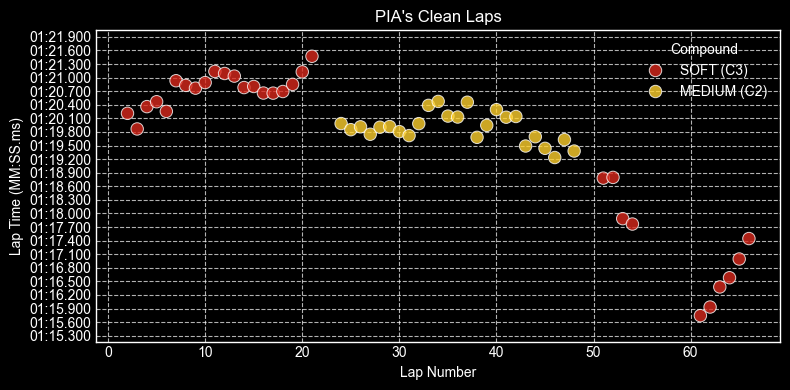

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


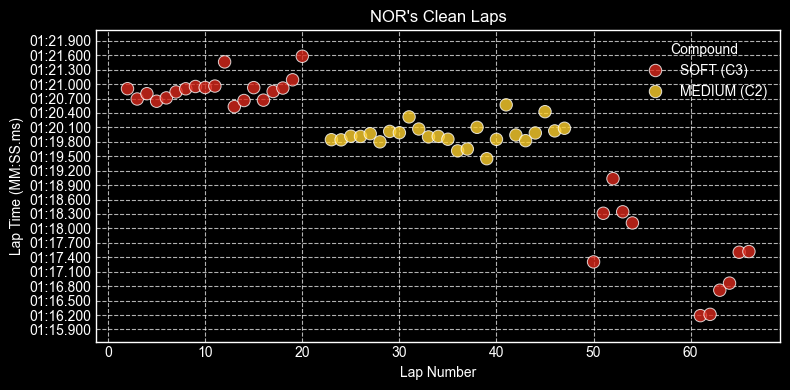

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


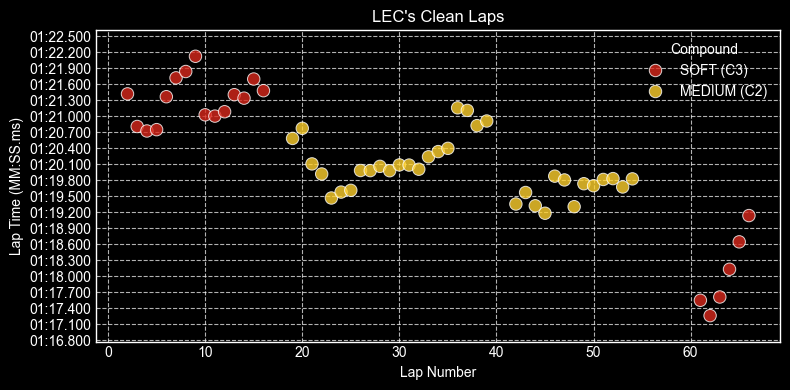

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


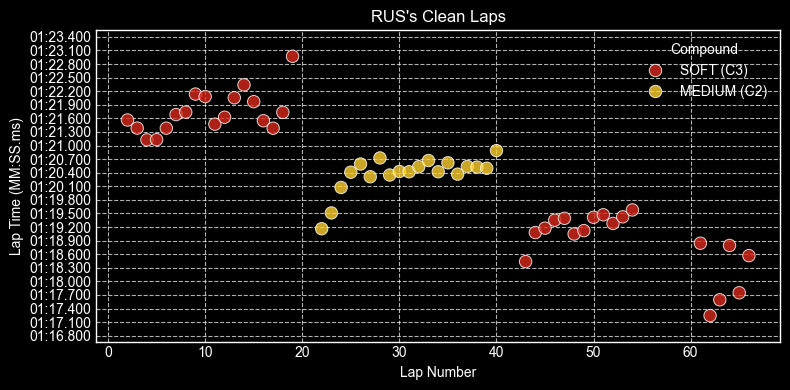

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


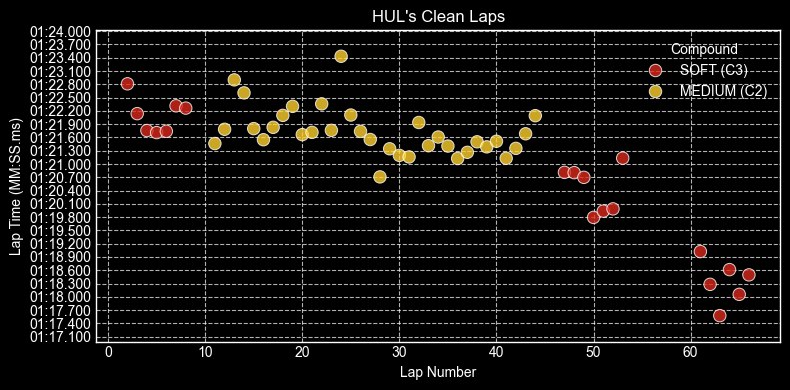

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


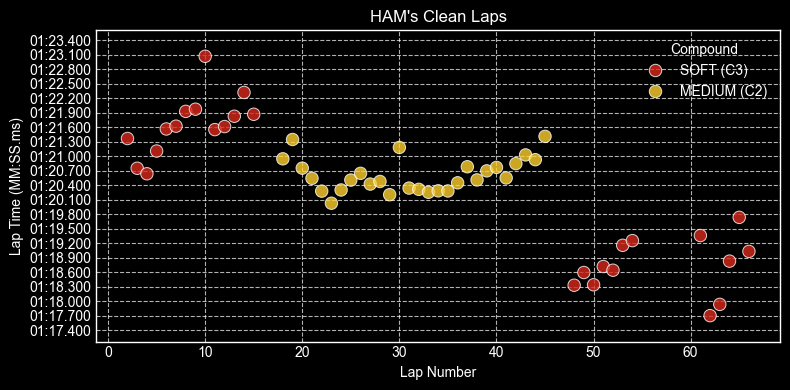

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


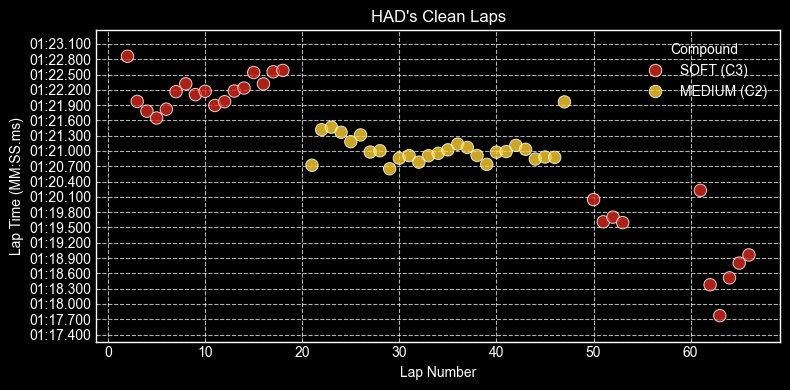

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


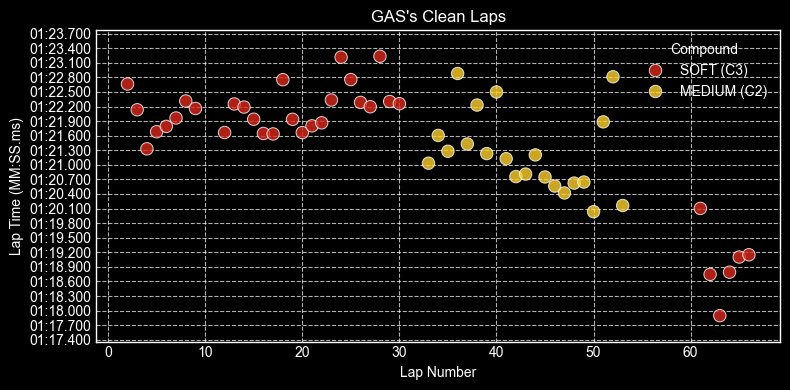

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


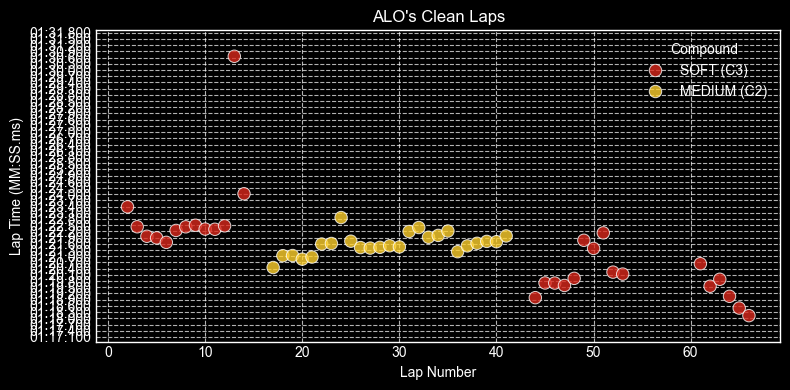

C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\3889325203.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
C:\Users\mpoli\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\fastf1\plotting\__init__.py:84: FutureWarning: INCOMPATIBLE with 2025 season! COMPOUND_COLORS is deprecated and will be removed in a future version.
  warnings.warn(f"INCOMPATIBLE with 2025 season! {name} is deprecated "


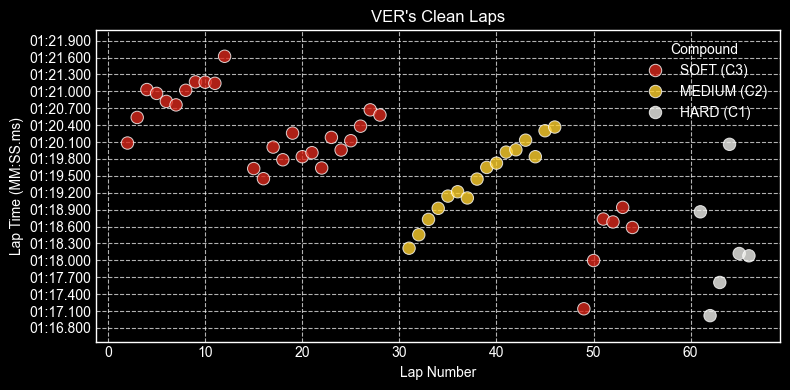

In [27]:

if current_session is not None:
    clean_laps = get_clean_laps(laps_df, TARGET_YEAR, race_name)  
    # Loading all drivers from the session
    drivers = current_session.drivers
    drivers = results_df['Abbreviation'].unique()  # Get unique drivers from results
    top_10_drivers = results_df['Abbreviation'].unique()[:10]  # Get the first 10 unique drivers from results

    print(top_10_drivers)
    for driver in top_10_drivers:
        driver_laps = clean_laps[clean_laps['Driver'] == driver]

        if not driver_laps.empty:
            if 'pirelliCompound' in driver_laps.columns and 'Compound' in driver_laps.columns:
                 driver_laps['CompoundDisplay'] = driver_laps['Compound'] + ' (' + driver_laps['pirelliCompound'] + ')'
            else:
                 driver_laps['CompoundDisplay'] = driver_laps['Compound'] 
                 print(f"Warning: 'pirelliCompound' not found for {driver}. Legend will use generic compound names.")

            unique_display_compounds = driver_laps['CompoundDisplay'].unique()
            custom_palette = {}
            for display_name in unique_display_compounds:
                generic_compound = display_name.split(' ')[0]
                custom_palette[display_name] = plotting.COMPOUND_COLORS.get(generic_compound, 'gray')

        if not driver_laps.empty:
            # 
            plt.figure(figsize=(8, 4))
            sns.scatterplot(data=driver_laps, 
                            x='LapNumber', 
                            y='LapTime_seconds', 
                            hue='CompoundDisplay', 
                            markers={True: 'X', False: 'o'}, 
                            s=80, alpha=0.8, 
                            palette=custom_palette) 
            plt.title(f"{driver}""'s Clean Laps")
            plt.xlabel('Lap Number')
            plt.ylabel('Lap Time (MM:SS.ms)') 
            ax = plt.gca() 
            ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_laptime_mmssms(y)))
            
            if not driver_laps['LapTime_seconds'].empty:
                min_time = driver_laps['LapTime_seconds'].min()
                max_time = driver_laps['LapTime_seconds'].max()
                margin = (max_time - min_time) * 0.1
                ax.set_ylim(min_time - margin, max_time + margin)
                
                ## Ajusting the y-axis ticks to show every 0.3 seconds
                ax.yaxis.set_major_locator(MultipleLocator(0.3)) 

            plt.grid(True, linestyle='--', alpha=0.7)
            plt.legend(title='Compound') 
            plt.tight_layout()
            

            plt.show() 
else:
    print("No session has been loaded")



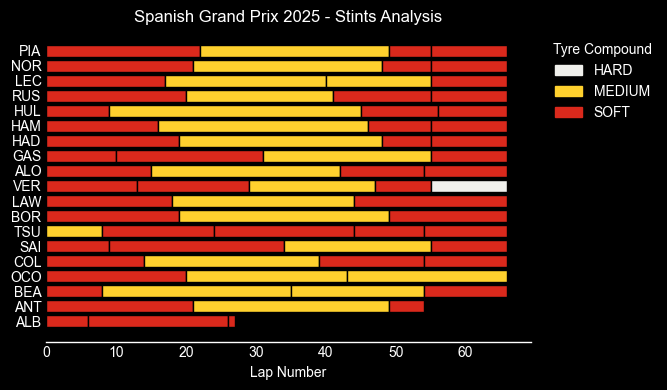

In [28]:
import matplotlib.patches as mpatches
stints = laps_df[["Driver", "Stint", "Compound", "LapNumber"]]
stints = stints.groupby(["Driver", "Stint", "Compound"])
stints = stints.count().reset_index()
stints = stints.rename(columns={"LapNumber": "StintLength"})

unique_compounds = stints["Compound"].unique()

legend_handles = []
for compound in sorted(unique_compounds):
    compound_color = fastf1.plotting.get_compound_color(
        compound, session=current_session
    )
    patch = mpatches.Patch(color=compound_color, label=compound)
    legend_handles.append(patch)


fig, ax = plt.subplots(figsize=(8, 4))
for driver in drivers:
    driver_stints = stints.loc[stints["Driver"] == driver]

    previous_stint_end = 0
    for idx, row in driver_stints.iterrows():
        compound_color = fastf1.plotting.get_compound_color(
            row["Compound"], session=current_session
        )
        plt.barh(
            y=driver,
            width=row["StintLength"],
            left=previous_stint_end,
            color=compound_color,
            edgecolor="black",
            fill=True
        )
        previous_stint_end += row["StintLength"]

plt.title(f'{current_session.event["EventName"]} {TARGET_YEAR} - Stints Analysis')
plt.xlabel("Lap Number")
plt.grid(False)
ax.invert_yaxis()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.legend(
    handles=legend_handles,
    title='Tyre Compound',
    bbox_to_anchor=(1.02, 1), 
    loc='upper left'
)

plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.show()

## Team Pace Comparision 

This section presents an in-depth analysis of team performance and individual driver lap times during the
[**Austrian Grand Prix 2025 Round 11** - or update with actual race name and details].


The **Team Pace Comparison** is visualized using a **Box Plot (Box-and-Whisker Plot)**. This type of graph effectively displays the distribution and dispersion of lap times for each team.

* **The Box:** Represents the **Interquartile Range (IQR)**, containing the middle 50% of a team's lap times. A shorter box indicates higher consistency in pace.
    * **Middle Line:** The **median** lap time (50th percentile). This is the team's typical pace. A lower median (closer to 0 on the Y-axis) means a faster team.
    * **Bottom of the Box:** The 25th percentile (Q1).
    * **Top of the Box:** The 75th percentile (Q3).
* **The Whiskers:** Extend from the box, showing the overall spread of lap times, typically up to 1.5 times the IQR.
* **Individual Points (Circles):** These represent **outliers** – lap times that are significantly faster or slower than the rest of the team's laps.

**Key Insights from this plot:**
* Fast team generally show lower median lap times, indicating stronger overall pace.
* The height of the boxes reveals consistency. For instance, a very compact box suggests stable lap times. A team can be consistency but not necessarily fast (low median).
* Outlier probably means lower laps, when battling for a position or traffic interferes. We cleaned the data to remove VSC and SC, but not this kind of situation.



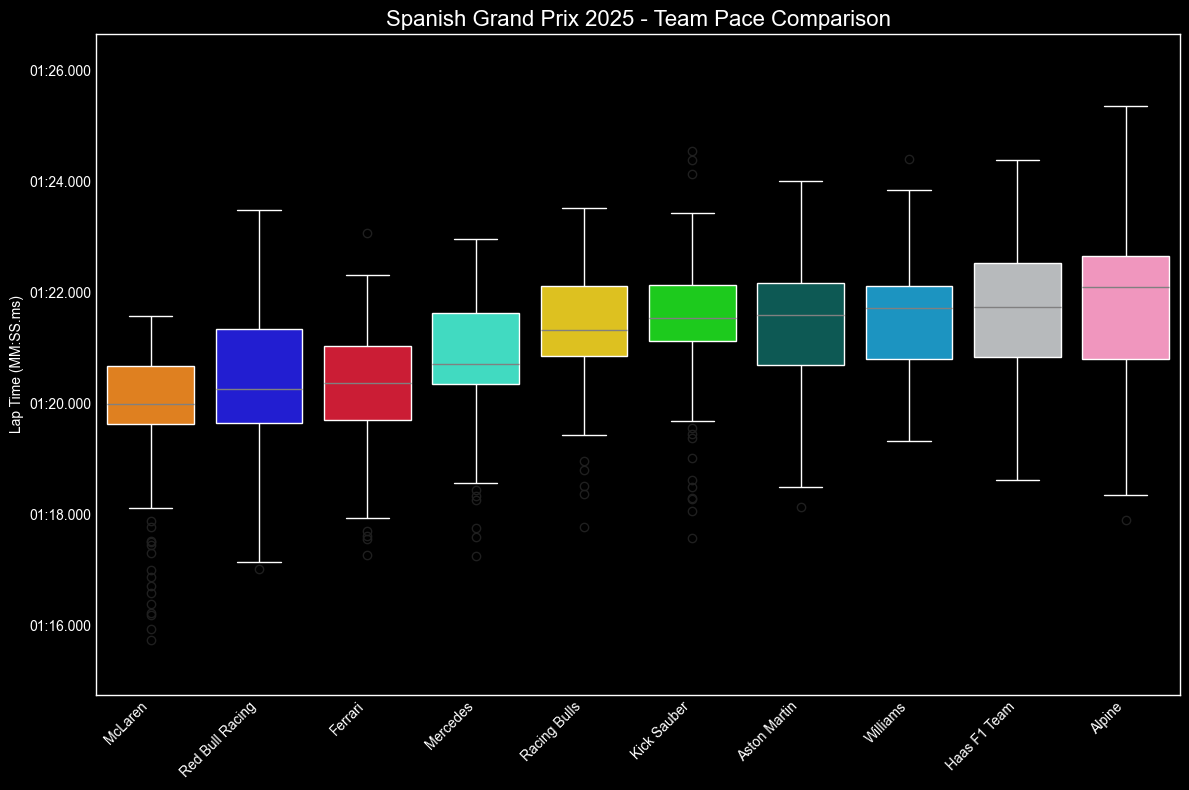

In [29]:
team_order = (
    clean_laps[["Team", "LapTime_seconds"]]
    .groupby("Team")
    .median()["LapTime_seconds"]
    .sort_values()
    .index
)
team_palette = {team: fastf1.plotting.get_team_color(team, session=current_session)
                for team in team_order}

fig, ax = plt.subplots(figsize=(12, 8)) 
sns.boxplot(
    data=clean_laps,
    x="Team",
    y="LapTime_seconds",
    hue="Team",
    order=team_order,
    palette=team_palette,
    whiskerprops=dict(color="white"),
    boxprops=dict(edgecolor="white"),
    medianprops=dict(color="grey"),
    capprops=dict(color="white"),
    legend=False 
)

plt.title(f"{current_session.event['EventName']} {TARGET_YEAR} - Team Pace Comparison", fontsize=16)
plt.grid(visible=False)
ax.set(xlabel=None, ylabel="Lap Time (MM:SS.ms)")
plt.xticks(rotation=45, ha='right') 

ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_laptime_mmssms(y)))

if not clean_laps['LapTime_seconds'].empty:
    min_time = clean_laps['LapTime_seconds'].min()
    max_time = clean_laps['LapTime_seconds'].max() - 5
    
    margin = (max_time - min_time) * 0.1
    ax.set_ylim(min_time - margin, max_time + margin)
    
    ax.yaxis.set_major_locator(MultipleLocator(2))

plt.tight_layout()
plt.show()

## Comparing drivers pace



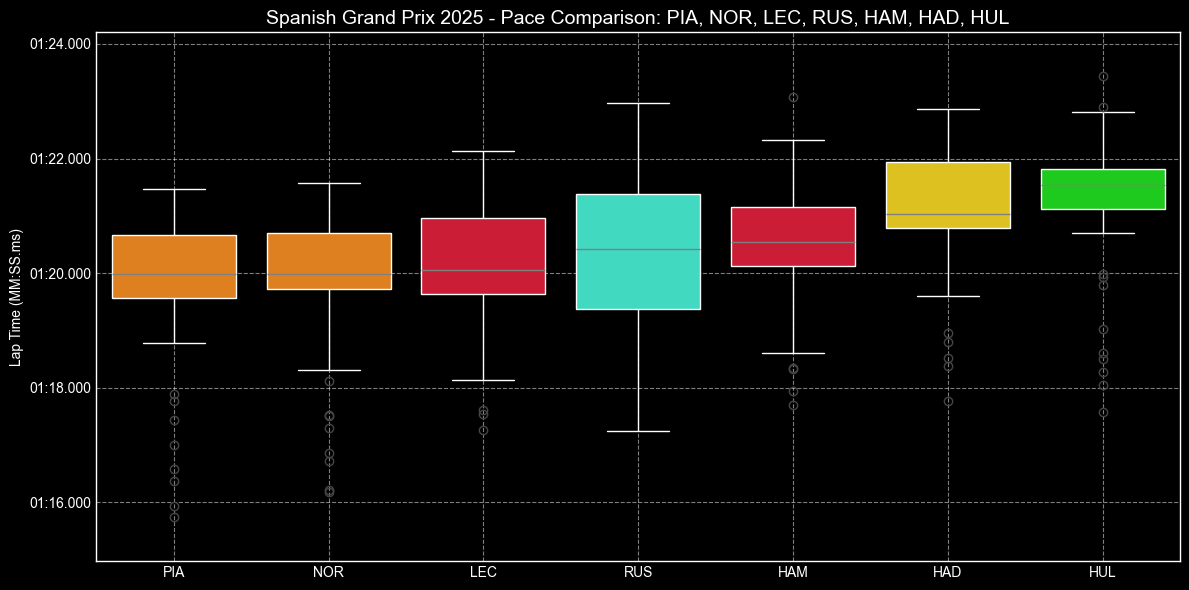

In [30]:
selected_drivers = ['NOR', 'PIA', 'RUS', 'LEC', 'HUL', 'HAM', 'HAD']
driver_palette = {}
selected_drivers_laps_dict = {}
all_selected_drivers_laps_combined = pd.DataFrame()

for driver in selected_drivers:
    current_driver_laps = clean_laps[clean_laps['Driver'] == driver].copy()

    if not current_driver_laps.empty:
        selected_drivers_laps_dict[driver] = current_driver_laps
        current_driver_laps['DriverAbbr'] = driver
        all_selected_drivers_laps_combined = pd.concat([all_selected_drivers_laps_combined, current_driver_laps], ignore_index=True)
    else:
        print(f"No laps found for driver {driver}.")

    try:
        color = fastf1.plotting.get_driver_color(driver, session=current_session)
        driver_palette[driver] = color
    except KeyError:
        print(f"Could not find color for driver {driver}. Using black as default.")
        driver_palette[driver] = '#000000'

if all_selected_drivers_laps_combined.empty:
    print("Combined DataFrame is empty. Box Plot cannot be generated. Check driver filtering.")
else:
    driver_order_for_plot = (
        all_selected_drivers_laps_combined[["DriverAbbr", "LapTime_seconds"]]
        .groupby("DriverAbbr")
        .median()["LapTime_seconds"]
        .sort_values()
        .index.tolist()
    )

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.boxplot(
        data=all_selected_drivers_laps_combined,
        x="DriverAbbr",
        y="LapTime_seconds",
        hue="DriverAbbr",
        order=driver_order_for_plot,
        palette=driver_palette,
        whiskerprops=dict(color="white"),
        boxprops=dict(edgecolor="white"),
        medianprops=dict(color="grey"),
        capprops=dict(color="white"),
        showfliers=True,
        legend=False 
    )

    title_drivers_str = ", ".join(driver_order_for_plot)
    plt.title(f"{current_session.event['EventName']} {TARGET_YEAR} - Pace Comparison: {title_drivers_str}", fontsize=14)
    plt.grid(visible=True, linestyle='--', alpha=0.5)
    ax.set(xlabel=None, ylabel="Lap Time (MM:SS.ms)")

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_laptime_mmssms(y)))
    min_time = all_selected_drivers_laps_combined['LapTime_seconds'].min()
    max_time = all_selected_drivers_laps_combined['LapTime_seconds'].max()
    margin = (max_time - min_time) * 0.1
    ax.set_ylim(min_time - margin, max_time + margin)
    ax.yaxis.set_major_locator(MultipleLocator(2))

    plt.tight_layout()
    plt.show()

    

# Analyzing the big picture

Here, we start to analyzing the problem as a whole, identifying patterns in the data, trying to define a good metric for a good strategy in specific conditions

In [31]:
target_gp_name = 'Hungarian Grand Prix' 
start_year_analysis = 2022
end_year_analysis = 2025

all_results_data_by_year = {}
all_laps_data_by_year = {}
all_stints_data_by_year = {}
all_weather_data_by_year = {}
date = {}


print(f"\n--- Starting comprehensive data collection for {target_gp_name} from {start_year_analysis} to {end_year_analysis-1} ---")

for year in range(start_year_analysis, end_year_analysis):
    print(f"\n--- Collecting data for {target_gp_name} in Season: {year} ---")
    schedule = fastf1.get_event_schedule(year)
    target_event = schedule[schedule['EventName'].str.contains(target_gp_name, case=False, na=False)]

    if target_event.empty:
        print(f"  {target_gp_name} not found in {year} schedule, skipping.")
        continue
    
    target_race_round_row = target_event[target_event['EventFormat'].isin(['conventional', 'sprint'])]
        
    if target_race_round_row.empty:
        print(f"  No 'conventional' or 'sprint' race event found for {target_gp_name} in {year}, skipping.")
        continue

    round_num = target_race_round_row['RoundNumber'].iloc[0]
    actual_event_name = target_race_round_row['EventName'].iloc[0] 

    print(f"  Found {actual_event_name} as Round {round_num} in {year}. Loading session...")

    session = fastf1.get_session(year, round_num, 'R') 
    session.load(laps=True, telemetry=True, weather=True, messages=True)

    laps_df = session.laps.copy()
    results_df = session.results.copy()
    
    if 'LapTime_seconds' not in laps_df.columns:
        laps_df['LapTime_seconds'] = laps_df['LapTime'].dt.total_seconds()

    race_name = session.event['EventName']
    json_path = 'compounds.json'
    with open(json_path, 'r') as file:
        compounds_data = json.load(file)
    
    year_str = str(year)
    
    if year_str in compounds_data['data']:
        compounds_for_year = compounds_data['data'][year_str]
        gp_compound_mapping = compounds_for_year.get(target_gp_name)

        if gp_compound_mapping:
            laps_df['pirelliCompound'] = laps_df['Compound'].map(gp_compound_mapping)
            
            laps_df['pirelliCompound'] = laps_df['pirelliCompound'].fillna(laps_df['Compound'])
            
            print(f" 'pirelliCompound' column created for {target_gp_name} {year}.")

        else:
            print(f" Warning: No compound mapping found in JSON for '{target_gp_name}' in year {year}. 'pirelliCompound' not created.")
    else:
        print(f" Warning: Year {year} not found in 'compounds.json'. 'pirelliCompound' not created.")
        laps_df['pirelliCompound'] = laps_df['Compound']

    all_results_data_by_year[year] = results_df
    all_laps_data_by_year[year] = laps_df
    all_stints_data_by_year[year] = laps_df[["Driver", "Stint", "Compound", "LapNumber","pirelliCompound"]]
    all_stints_data_by_year[year] = all_stints_data_by_year[year].groupby(["Driver", "Stint", "Compound", "pirelliCompound"])
    all_stints_data_by_year[year] = all_stints_data_by_year[year].count().reset_index() 
    all_stints_data_by_year[year] = all_stints_data_by_year[year].rename(columns={"LapNumber": "StintLength"})
    all_weather_data_by_year[year] = session.weather_data
    date[year]= session.date
    
    print(f"Session data loaded for: {race_name} {year} Round {round_num}")
    print(f"Total laps: {len(laps_df)}, Total results: {len(results_df)}")


   

core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data



--- Starting comprehensive data collection for Hungarian Grand Prix from 2022 to 2024 ---

--- Collecting data for Hungarian Grand Prix in Season: 2022 ---
  Found Hungarian Grand Prix as Round 13 in 2022. Loading session...


req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data


 'pirelliCompound' column created for Hungarian Grand Prix 2022.
Session data loaded for: Hungarian Grand Prix 2022 Round 13
Total laps: 1383, Total results: 20

--- Collecting data for Hungarian Grand Prix in Season: 2023 ---
  Found Hungarian Grand Prix as Round 11 in 2023. Loading session...


req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '11', '44', '81', '63', '16', '55', '14', '18', '23', '77', '3', '27', '22', '24', '20', '2', '31', '10']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req    

 'pirelliCompound' column created for Hungarian Grand Prix 2023.
Session data loaded for: Hungarian Grand Prix 2023 Round 11
Total laps: 1252, Total results: 20

--- Collecting data for Hungarian Grand Prix in Season: 2024 ---
  Found Hungarian Grand Prix as Round 13 in 2024. Loading session...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '44', '16', '1', '55', '11', '63', '22', '18', '14', '3', '27', '23', '20', '77', '2', '31', '24', '10']


 'pirelliCompound' column created for Hungarian Grand Prix 2024.
Session data loaded for: Hungarian Grand Prix 2024 Round 13
Total laps: 1355, Total results: 20


## Most Common Strategy

In this section, we will analize the most common strategy for the selected grand prix in the past regulations.


--- Analyzing Most Used Strategies for Hungarian Grand Prix across years ---

Top 5 Most Used Strategies for Hungarian Grand Prix:


,Strategy,Count
0,C4-C3-C3,17
1,C4-C3-C4,12
2,C5-C3-C3,4
3,C3-C4-C4,3
4,C3-C2,3


C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\4152413751.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_strategies, x='Count', y='Strategy', ax=ax, palette='viridis')


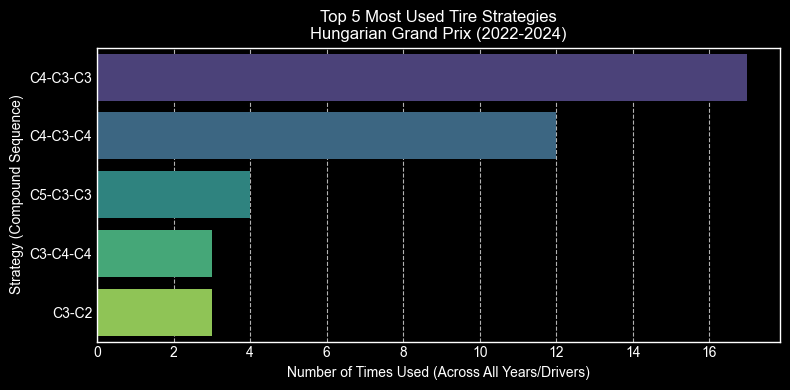

Plot saved as top_5_strategies_Hungarian_Grand_Prix.png


In [32]:
top_n_strategies = 5

all_strategies = []

print(f"\n--- Analyzing Most Used Strategies for {target_gp_name} across years ---")

for year, data_for_year in all_stints_data_by_year.items():
    if not data_for_year.empty: 
        stints_df = data_for_year.copy()
        
        driver_strategies = stints_df.groupby('Driver').agg(
            compound_sequence=('pirelliCompound', lambda x: tuple(x.tolist())) # Get ordered tuple of compounds
        ).reset_index()

        driver_strategies['strategy_string'] = driver_strategies['compound_sequence'].apply(lambda x: "-".join(x))
        
        # Add year to the strategy for context (useful for df_all_strategies)
        driver_strategies['year'] = year
        
        all_strategies.append(driver_strategies)
    else:
        print(f"  No stints data found for {year} {target_gp_name}, skipping.")

df_all_strategies = pd.concat(all_strategies, ignore_index=True)


# Count the frequency of each unique strategy string across all years
strategy_counts = df_all_strategies['strategy_string'].value_counts().reset_index()
strategy_counts.columns = ['Strategy', 'Count']

# Get the top N most frequent strategies
top_strategies = strategy_counts.head(top_n_strategies)
print(f"\nTop {top_n_strategies} Most Used Strategies for {target_gp_name}:")
display(top_strategies)

# Plotting the frequency of top strategies
fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=top_strategies, x='Count', y='Strategy', ax=ax, palette='viridis')

ax.set_xlabel('Number of Times Used (Across All Years/Drivers)')
ax.set_ylabel('Strategy (Compound Sequence)')
ax.set_title(f'Top {top_n_strategies} Most Used Tire Strategies\n{target_gp_name} ({start_year_analysis}-{end_year_analysis-1})')
ax.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(os.path.join(BASE_PLOT_DIR, f'top_{top_n_strategies}_strategies_{target_gp_name.replace(" ", "_")}.png'))
plt.show()
print(f"Plot saved as top_{top_n_strategies}_strategies_{target_gp_name.replace(' ', '_')}.png")




## Pace increase per compound



 'pirelliCompound' column created for Hungarian Grand Prix 2022.
 'pirelliCompound' column created for Hungarian Grand Prix 2023.
 'pirelliCompound' column created for Hungarian Grand Prix 2024.


C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\2982951129.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_laps['pirelliCompound'] = clean_laps['Compound'].map(gp_compound_mapping)
C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\2982951129.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_laps['pirelliCompound'] = clean_laps['pirelliCompound'].fillna(clean_laps['Compound'])
C:\Users\mpoli\AppData\Local\Temp\ipykernel_19776\2982951129.py:29: SettingWithCopyWarning: 
A value is trying 

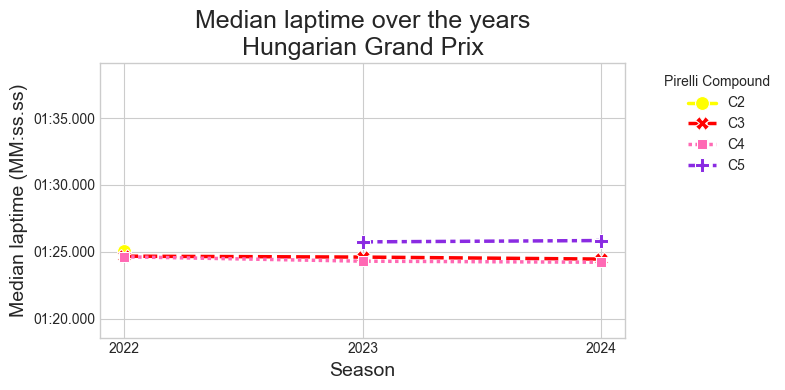

In [33]:
all_clean_laps = {}
median_times_by_compound = {}
min_time = 9000000000
max_time = -1
for year in range(start_year_analysis, end_year_analysis):
    all_clean_laps[year] = get_clean_laps(all_laps_data_by_year[year], year, target_gp_name)
    median_times_by_compound[year] = all_clean_laps[year].groupby('pirelliCompound')['LapTime_seconds'].median().reset_index()
    if all_clean_laps[year]['LapTime_seconds'].min() < min_time:
        min_time = all_clean_laps[year]['LapTime_seconds'].min()
    if all_clean_laps[year]['LapTime_seconds'].max() > max_time:
        max_time = all_clean_laps[year]['LapTime_seconds'].max()

all_medians_list = []
for year, df_median in median_times_by_compound.items():
    df_median['Year'] = year  
    all_medians_list.append(df_median)

evolution_df = pd.concat(all_medians_list, ignore_index=True)

custom_compound_palette = {
    'C1': '#A9A9A9',      
    'C2': '#FFFF00',      
    'C3': '#FF0000',      
    'C4': '#FF69B4',      
    'C5': '#8A2BE2',      
    'C6': '#0000FF',      
    'INTERMEDIATE': '#43B02A', 
    'WET': '#0067AD'     
}


plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 4))

sns.lineplot(
    data=evolution_df,
    x='Year',
    y='LapTime_seconds',
    hue='pirelliCompound',
    style='pirelliCompound',
    palette=custom_compound_palette,
    markers=True,
    markersize=10,
    linewidth=2.5,
    ax=ax
)

ax.set_title(f'Median laptime over the years\n{target_gp_name}', fontsize=18)
ax.set_xlabel('Season', fontsize=14)
ax.set_ylabel('Median laptime (MM:ss.ss)', fontsize=14)
ax.legend(title='Pirelli Compound', bbox_to_anchor=(1.05, 1), loc='upper left') 
ax.set_xticks(evolution_df['Year'].unique())
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_laptime_mmssms(y)))     
    
margin = ((max_time) - min_time) * 0.1 
ax.set_ylim(min_time - margin, max_time + margin)
ax.yaxis.set_major_locator(MultipleLocator(5))

plt.tight_layout()

plt.show()




## Comparing GP's in a different weather condition

GP's at the same circuit can be held in different times of the year, different weather conditions and more. Here we are going to compare these GP's, in order to extract the most important factors that affect the performance of the tyres and the results of the race.

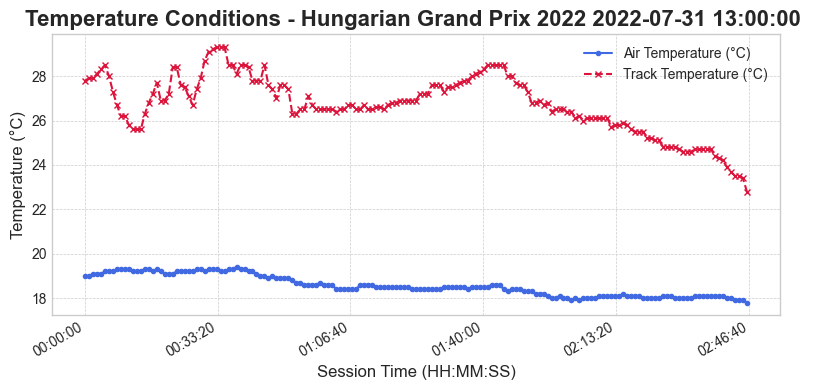

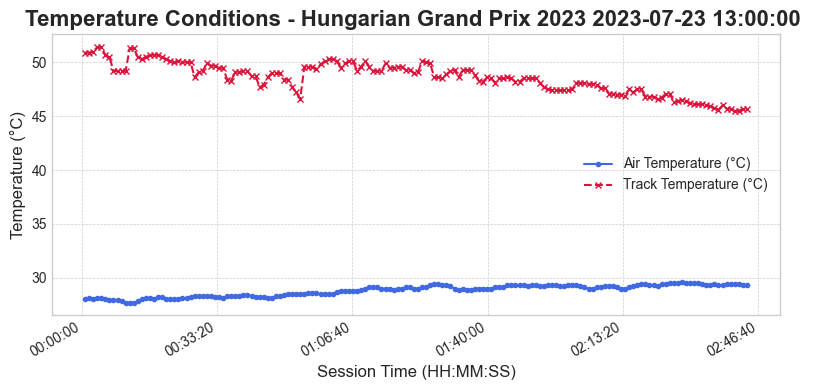

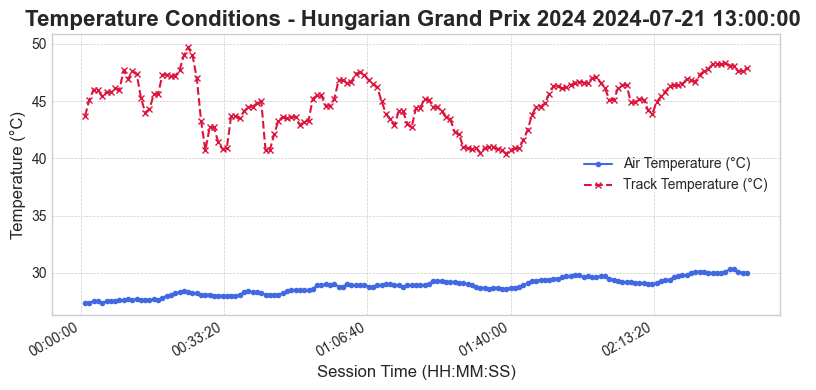

In [34]:
for year, weather_data in all_weather_data_by_year.items():
    
    if not weather_data.empty:
        fig, ax = plt.subplots(figsize=(8, 4))

        ax.plot(weather_data['Time'], weather_data['AirTemp'], label='Air Temperature (°C)', color='royalblue', marker='o', markersize=3, linestyle='-')
        ax.plot(weather_data['Time'], weather_data['TrackTemp'], label='Track Temperature (°C)', color='crimson', linestyle='--', marker='x', markersize=4)

        ax.set_title(f'Temperature Conditions - {target_gp_name} {year} {date[year]} ', fontsize=16, fontweight='bold')
        ax.set_xlabel('Session Time (HH:MM:SS)', fontsize=12)
        ax.set_ylabel('Temperature (°C)', fontsize=12)
        
        formatter = FuncFormatter(lambda x, pos: pd.to_timedelta(x).round('s').__str__().split()[-1])
        ax.xaxis.set_major_formatter(formatter)
        
        plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
        
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.tight_layout()

        
        plt.show()
        
    else:
        print(f"No data has been found for {year} {target_gp_name}.")




In [35]:
all_c1_laps_with_temp = []

for year in all_clean_laps.keys():
    print(f"Processing {year} data...")
    
    laps_df = all_clean_laps.get(year)
    weather_df = all_weather_data_by_year.get(year)

    if laps_df is None or weather_df is None or weather_df.empty:
        print(f"Laptime data for {year} missing. Skiping")
        continue

    c3_laps = laps_df[laps_df['pirelliCompound'] == 'C1'].copy()
    
    if c3_laps.empty:
        print(f"No lap with C1 has been found for {year}. Skiping.")
        continue

    c3_laps = c3_laps.sort_values(by='LapStartTime')
    weather_df = weather_df.sort_values(by='Time')

    merged_df = pd.merge_asof(
        left=c3_laps,
        right=weather_df,
        left_on='LapStartTime',
        right_on='Time',
        direction='nearest'
    )
    
    all_c1_laps_with_temp.append(merged_df)

if not all_c1_laps_with_temp:
    print("No lap data with C1 compound found.")
else:
    c3_performance_df = pd.concat(all_c1_laps_with_temp, ignore_index=True)
    c3_performance_df.dropna(subset=['LapTime_seconds', 'TrackTemp'], inplace=True)
    temp_bins = pd.cut(
        c3_performance_df['TrackTemp'],
        bins=range(20, 61, 5), 
        right=False 
    )
    c3_performance_df['TempBin'] = temp_bins.astype(str)
    c3_performance_df.dropna(subset=['TempBin'], inplace=True)


    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.boxplot(
        data=c3_performance_df,
        x='TempBin',
        y='LapTime_seconds',
        ax=ax,
        palette='coolwarm',
        order=sorted(c3_performance_df['TempBin'].unique()) 
    )

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_laptime_mmssms(y)))   
    max_time = c3_performance_df['LapTime_seconds'].max()
    min_time = c3_performance_df['LapTime_seconds'].min()

    margin = ((max_time) - min_time) * 0.1 
    ax.set_ylim(min_time - margin, max_time + margin)
    ax.yaxis.set_major_locator(MultipleLocator(5))
    
    ax.set_title('C1 Performance vs. Track Temperature', fontsize=18, fontweight='bold')
    ax.set_xlabel('Track Temperature (°C)', fontsize=14)
    ax.set_ylabel('Lap Time (MM:SS.ms)', fontsize=14)
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    
    plt.show()
    



Processing 2022 data...
No lap with C1 has been found for 2022. Skiping.
Processing 2023 data...
No lap with C1 has been found for 2023. Skiping.
Processing 2024 data...
No lap with C1 has been found for 2024. Skiping.
No lap data with C1 compound found.


## Finding the metrics to a good strategy

In this section, we will try to find the metrics to a good strategy. We will use the following idea:

**Strategy Score**: It's a parameter that measures how good a strategy is. The higher the score, the better the strategy. We will use the following formula:

$ \text{Strategy Score} = \text{F1 Points} + C \times (\text{Positions Gained/Lost}) $

Where C is a constant that tell how much we want to reward points for positions gained/lost. We will use C = 3, but different GP's and situations may require more or less.



In [36]:
all_strategy_score = {}
merged_data = {}

C = 3
for year in all_results_data_by_year.keys():
  data_for_year = all_results_data_by_year[year]
  finished_drivers_results = data_for_year[
     ~data_for_year['Status'].str.contains(
        'Retired', 
        case=False, na=False, regex=True
    )
  ].copy()
  finished_drivers_results['Positions_Gained_Lost'] = finished_drivers_results['GridPosition'] - finished_drivers_results['Position']
  finished_drivers_results['Strategy_Score'] = finished_drivers_results['Points'] + C * finished_drivers_results['Positions_Gained_Lost']
  all_strategy_score[year] = finished_drivers_results

  stints_df = all_stints_data_by_year[year]
  driver_strategies = stints_df.groupby('Driver').agg(
            compound_sequence=('pirelliCompound', lambda x: tuple(x.tolist()))
        ).reset_index()
  driver_strategies['strategy_string'] = driver_strategies['compound_sequence'].apply(lambda x: "-".join(x))
  merged_data[year] = pd.merge(driver_strategies, all_strategy_score[year], left_on='Driver', right_on='Abbreviation')





--- Plotting Strategy Breakdown for Year 2022 ---


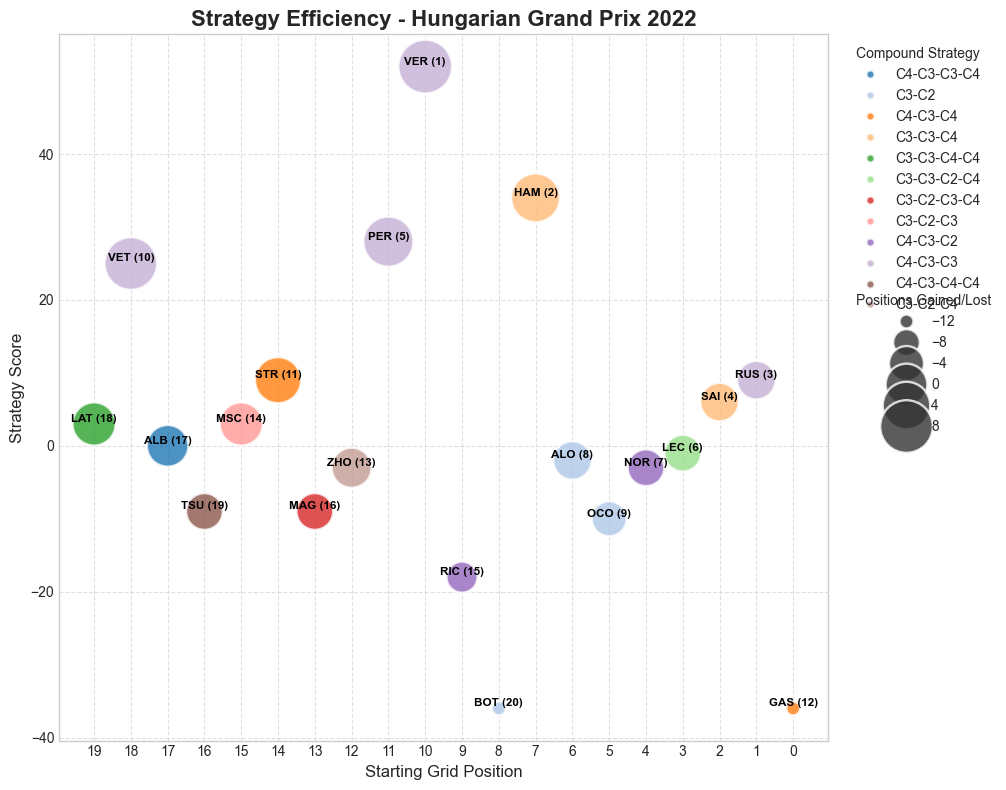


--- Plotting Strategy Breakdown for Year 2023 ---


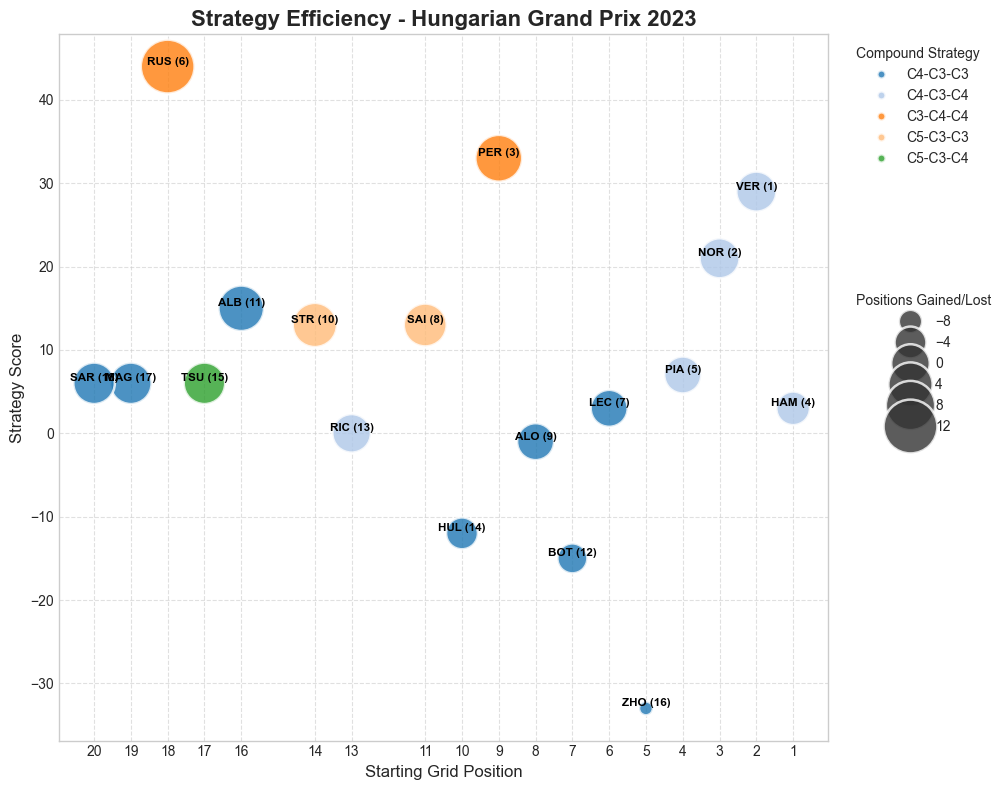


--- Plotting Strategy Breakdown for Year 2024 ---


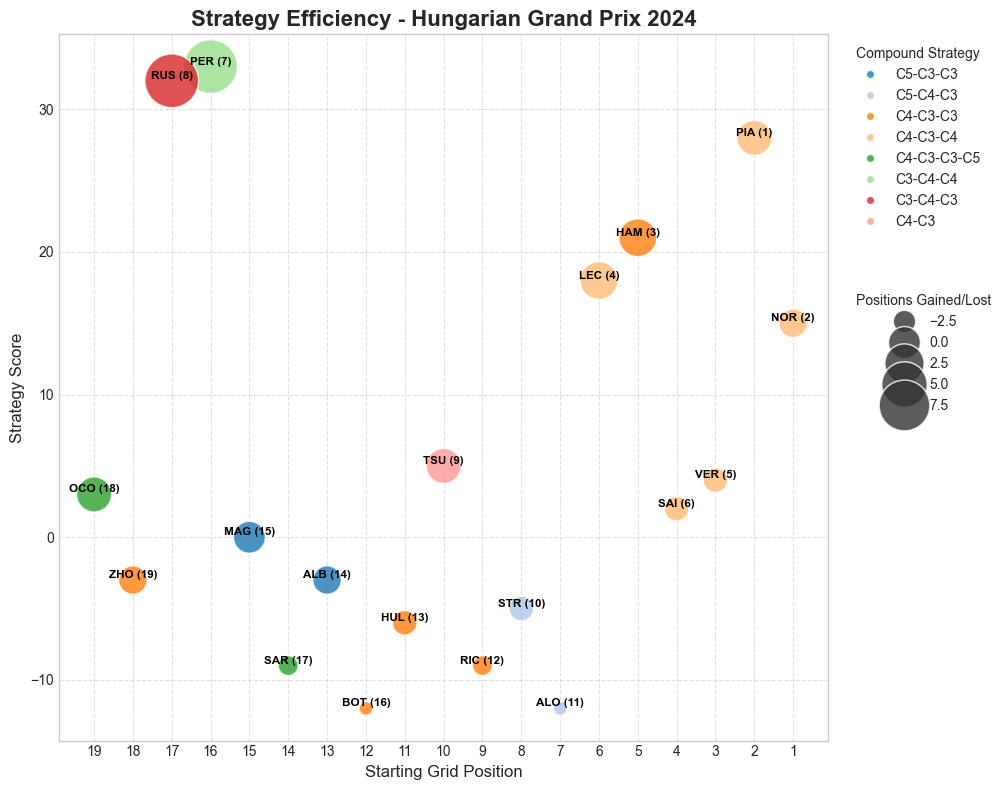


--- Plotting for all years finished ---


In [37]:
for year, df_plot_data in merged_data.items():
    print(f"\n--- Plotting Strategy Breakdown for Year {year} ---")

    if df_plot_data.empty:
        print(f"    No merged data for year {year}, skipping plot.")
        continue

    plot_data_filtered = df_plot_data.dropna(subset=[
        'strategy_string', 'Driver', 'GridPosition', 'Position',
        'Strategy_Score', 'Positions_Gained_Lost'
    ]).copy()

    if plot_data_filtered.empty:
        print(f"    No valid data for plotting after NaN cleanup for year {year}. Skipping plot.")
        continue

    fig, ax = plt.subplots(figsize=(12, 8))

    sns.scatterplot(
        data=plot_data_filtered,
        x='GridPosition',
        y='Strategy_Score',
        hue='strategy_string',
        size='Positions_Gained_Lost',
        sizes=(100, 1500),
        palette='tab20',
        alpha=0.8,
        ax=ax
    )

    for index, row in plot_data_filtered.iterrows():
        annotation_text = f"{row['Driver']} ({int(row['Position'])})"
        ax.text(
            row['GridPosition'],
            row['Strategy_Score'],
            annotation_text,
            horizontalalignment='center',
            verticalalignment='bottom',
            size='small',
            color='black',
            weight='bold'
        )

    ax.invert_xaxis()
    ax.set_xticks(sorted(plot_data_filtered['GridPosition'].unique()))
    plt.title(f"Strategy Efficiency - {target_gp_name} {year}", fontsize=16, fontweight='bold')
    plt.xlabel('Starting Grid Position', fontsize=12)
    plt.ylabel('Strategy Score', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    handles, labels = ax.get_legend_handles_labels()
    num_strategies = len(plot_data_filtered['strategy_string'].unique())

    legend1 = ax.legend(
        handles[1:num_strategies+1],
        labels[1:num_strategies+1],
        title='Compound Strategy',
        bbox_to_anchor=(1.02, 1),
        loc='upper left'
    )
    ax.add_artist(legend1)

    legend2 = ax.legend(
        handles[num_strategies+2:],
        labels[num_strategies+2:],
        title='Positions Gained/Lost',
        bbox_to_anchor=(1.02, 0.65),
        loc='upper left'
    )

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

print("\n--- Plotting for all years finished ---")